[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [1]:
# Install the Crunch CLI
%pip install --upgrade crunch-cli

# Setup your local environment
!crunch setup --notebook structural-break hello --token eKgpbO5byPBKxmWVK6E12tkV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: requirements-parser
    Found existing installation: requirements-parser 0.9.0
    Uninstalling requirements-parser-0.9.0:
      Successfully uninstalled requirements-parser-0.9.0
crunch-cli, version 7.5.0
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate

# Your model

## Setup

In [2]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

In [3]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 7.5.0
available ram: 12.67 gb
available cpu: 2 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [4]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: (arbitrary) The time step within each time series, which is regularly sampled

**Columns:**
- `value`: The values of the time series at each given time step
- `period`: whether you are in the first part of the time series (`0`), before the presumed break point, or in the second part (`1`), after the break point

In [13]:
X_train = X_train.reset_index()#[X_train.index == [0, :]]


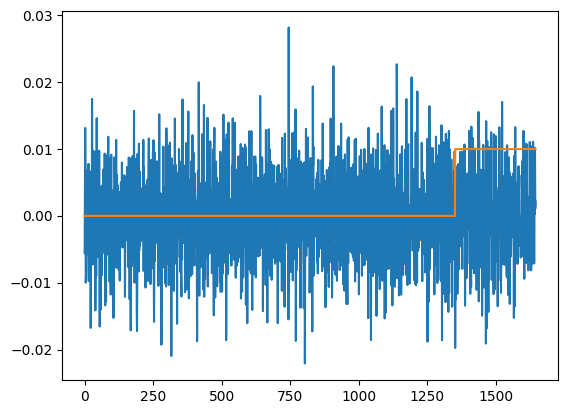

In [19]:
import matplotlib.pyplot as plt

plt.plot(X_train[X_train.id == 0]['time'], X_train[X_train.id == 0]['value'])
plt.plot(X_train[X_train.id == 0]['time'], X_train[X_train.id == 0]['period']/100)

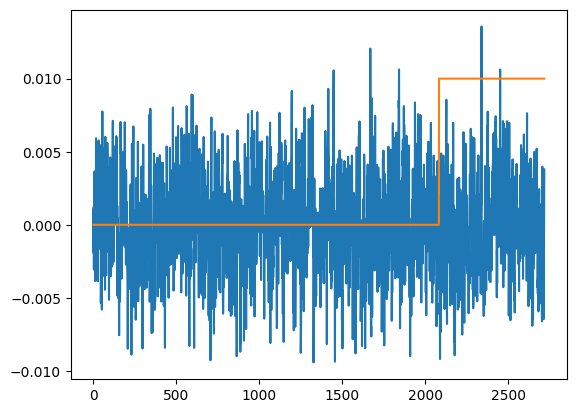

In [26]:
from random import randint
k = randint(0, 10_000)
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['value'])
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['period']/100)

In [31]:
X_train[X_train.id == k]['value'].describe()

,value
count,2717.000000
mean,-0.000027
std,0.003341
min,-0.009421
25%,-0.002325
50%,-0.000042
75%,0.002118
max,0.013569


In [37]:
(X_train[X_train.id == k]['value'].iloc[1:].reset_index() - X_train[X_train.id == k]['value'].iloc[:-1].reset_index()).apply(abs).describe()

,index,value
count,2716.0,2.716000e+03
mean,1.0,2.601070e-03
std,0.0,1.996286e-03
min,1.0,8.388938e-07
25%,1.0,1.014963e-03
50%,1.0,2.177718e-03
75%,1.0,3.751050e-03
max,1.0,1.525442e-02


In [38]:
X_train[X_train.id == k]['value']

,value
13859611,0.001021
13859612,-0.001936
13859613,0.001215
13859614,-0.003060
13859615,-0.001641
...,...
13862323,-0.006455
13862324,-0.000424
13862325,-0.001797
13862326,0.000767


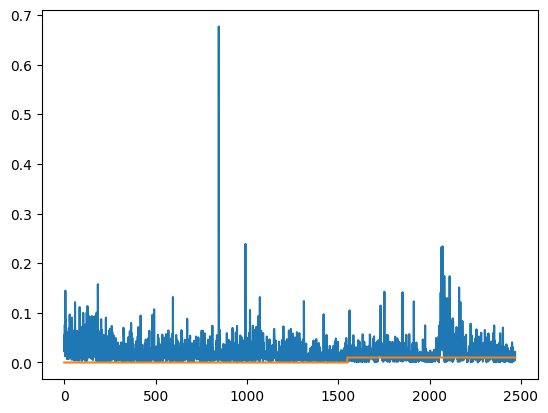

In [42]:
from random import randint
k = randint(0, 10_000)
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['value'].apply(abs))
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['period']/100)

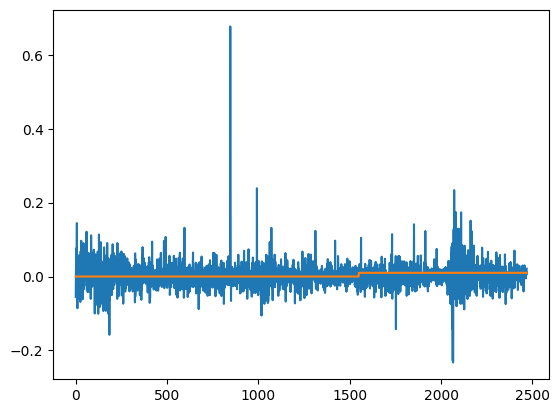

In [45]:
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['value'])
plt.plot(X_train[X_train.id == k]['time'], X_train[X_train.id == k]['period']/100)

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a time series id has a structural break, or not, from the presumed break point on.

**Index:**
- `id`: the ID of the time series

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [ ]:
y_train

id
0         True
1         True
2        False
3         True
4        False
         ...  
9996     False
9997      True
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [ ]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [ ]:
X_test[0]

value  period
id    time                  
10001 0    -0.020657       0
      1    -0.005894       0
      2    -0.003052       0
      3    -0.000590       0
      4     0.009887       0
...              ...     ...
      2517  0.005084       1
      2518 -0.024414       1
      2519 -0.014986       1
      2520  0.012999       1
      2521 -0.022138       1

[2522 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)